# Create the Colour Feature Sets
Here we take the R, G, B (_Red, Green & Blue_) value counts for the generation of our feature dataset. <br/>
This is done by first resizing the image to 10,000 pixels (_100x100_). Then counting the number of occuances of each of the R, G, B values. This results in 768 feature values per Artwork.

In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sqlite3
from numpy import savez_compressed
from sklearn.model_selection import train_test_split

In [2]:
# define array names used in tile colour files
COLOURS      = "arr_0"
TILE_TAGS    = "arr_1"
IMAGE_TAGS   = "arr_2"
RANDOM_STATE = 42

In [3]:
# define file paths
data_file_path  = "./data/"
image_file_path = "".join([data_file_path, "images/"]) 
colour_sets     = "".join([data_file_path, "colour_sets/"]) 

## Connect to the Database

In [4]:
# Create a DB connection between python and the file system
conn = sqlite3.connect(''.join([data_file_path,"/database/artist.db"]))

## Helper Functions

The function <code>colour_count()</code> processes a single layer of the __R, G, B__ (_Red, Grenn, Blue_) colour scheme. It counts the number of occurances of each of the values between 0 - 255. It is possible that some values are not present. In such a case, a _0_ value is inserted. An array of the totals is returned. This function is called three times by the <code>image_process()</code> function to complete the colour count analysis.

In [5]:
def colour_count(colour_array):
    
    # select all unique colours and then count occurances of each
    unique_values_count = np.unique(colour_array, return_counts = True)
    
    # NOTE: an image may not have a occurance of every colour value between 0-255
    #       therefore we must create an array with values 0-255 and then delete
    #       from it all values that we have identified. this gives us an array
    #       of missing values.
    
    # create array of missing values
    missing_values = np.delete(np.array(range(0,256)), np.unique(colour_array))
    
    # create an array of zeros the same length as the array of missing values
    missing_values_zeros = np.zeros((1, len(missing_values))).astype(int)[0]
    
    # append the array of missing values to the end of the array of unique values
    unique_values_and_missing_values = np.append(unique_values_count[0],missing_values).astype(int)
    
    # append the array of zeros to the end of the array of unique value counts
    values_count_and_missing_values_zeros = np.append(unique_values_count[1],missing_values_zeros)
    
    # NOTE: at this point both arrays contain the same number of values. both arrays
    #       are in the same order, but not in numerical order 
    return [unique_values_and_missing_values, values_count_and_missing_values_zeros]

 The function <code>image_process()</code> takes the __path__ of an image file and opens it using the __R, G, B__ colour scheme. The image is resize to 100 x 100 pixels. Regardless of its original dimensions. This is to ensure all images consist of the same number of pixels for analysis (_100 x 100 = 10,000 pixels_). The __R, G, B__ channels are split and are individually passed to the function <code>colour_count()</code>. The three colour value counts are then returned in the forma of a DataFrame.

In [6]:
def image_process(filename):
    
    # open the image
    img = Image.open(filename).convert('RGB')
    
    # NOTE: here we resize the image to 100 x 100 pixels (10000 pixels). this
    #       will normalize the data across all images of the artwork. otherwise
    #       a large image could impact the results more than a small image
    img = img.resize((100, 100), Image.ANTIALIAS)
    
    # extract the raw colour data
    red, green, blue = img.split()
    
    # convert data to numpy arrays
    na_red   = np.array(red)
    na_green = np.array(green)
    na_blue  = np.array(blue)
    
    # NOTE: when we get the count values of the unique colours they are not returned in 
    #       numerical order. so, a little trickery is performed. t
    #       1] when the values are returned, they are converted into a dataframe
    #       2] the dataframe is transposed to contain 2 columns with 256 rows
    #       3] the columns are renamed for ease
    #       4] the unique value column "colour_index" is set as the index
    #       5} the index is sorted into numerical order
    
    # count the colours
    colour_count_red   = pd.DataFrame(colour_count(na_red)  ).transpose().rename(columns={0: "colour_index", 1: "values"}).set_index("colour_index").sort_index()
    colour_count_green = pd.DataFrame(colour_count(na_green)).transpose().rename(columns={0: "colour_index", 1: "values"}).set_index("colour_index").sort_index()
    colour_count_blue  = pd.DataFrame(colour_count(na_blue) ).transpose().rename(columns={0: "colour_index", 1: "values"}).set_index("colour_index").sort_index()
    
    # NOTE: with all 3 colours ordered numerically, they can now be combined into a single dataframe
    
    # create new dataframe
    colour_values = pd.DataFrame()
    
    # add the colour values as columns
    colour_values["red"  ] = colour_count_red[  "values"]
    colour_values["green"] = colour_count_green["values"]
    colour_values["blue" ] = colour_count_blue[ "values"]
    
    # return the dataframe 
    return colour_values

The function <code>plot_colours()</code> takes the three layer colour count information and the __IMAGE_TAG__ as parameters. Using the __IMAGE_TAG__ we extract the artists name and the artworks title. The artwork is then plotted and to its right a bar plot of the __R, G, B__ colour total is generated. <br/> __NOTE:__ this function is designed to provide a visual representation of the colour count next to the artwork to help convey the principle behind the method. 

In [7]:
def plot_colours(colours, image_tag):
    
    # find the artist and artwork title
    query_string = """
SELECT NAME,
       TITLE
FROM   ARTWORK       AS A,
       ARTIST        AS B,
       ARTWORK_IMAGE AS C
WHERE  C.IMAGE_TAG  = '{}'
AND    C.ARTWORK_ID = A.ID
AND    A.ARTIST_ID  = B.ID""".format(image_tag)
    
    # extract data from the database
    query_result = pd.read_sql_query(query_string, conn)
    
    # define overall figure size
    plt.figure(figsize=(25, 5))

    # show the artwork
    ax1 = plt.subplot(1, 2, 1) 
    ax1.imshow(Image.open(image_path).convert('RGB'))
    ax1.axes.xaxis.set_visible(False)
    ax1.axes.yaxis.set_visible(False)
   
    # show the distribution of red, green & blue
    ax2 = plt.subplot(1, 2, 2) 
    ax2.bar(colours.index, colours["red"  ], color = "red"  , alpha = 0.2, width = 1)
    ax2.bar(colours.index, colours["green"], color = "green", alpha = 0.2, width = 1)
    ax2.bar(colours.index, colours["blue" ], color = "blue" , alpha = 0.2, width = 1)
    ax2.set_xlabel("Colour Value")
    ax2.set_ylabel("Occurrances of Colour Value")

    # title with figure with the artists name and artwork title
    plt.suptitle("".join([query_result["name"][0], " - ", query_result["title"][0] ]))
    
    # view our plot
    plt.show()

## View Some Examples of Colour Distribusions <br/>

For the demo we: <br/>

- Define an __IMAGE_TAG__ to use. <br/>
- Construct the __path__ to the image file. <br/>
- Pass the __path__ and the __IMAGE_TAG__ to the <code>plot_colurs()</code> function so that the artwork image and a histogram of the __R, G, B__ values are plotted side by side.

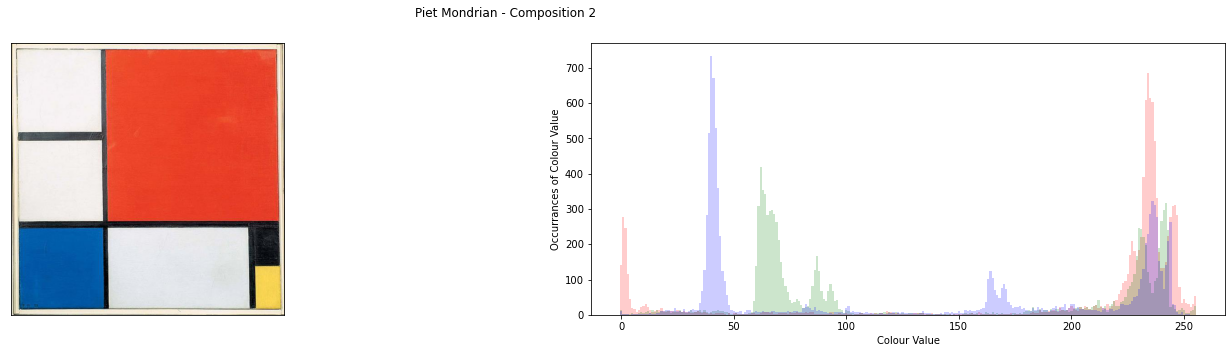

In [8]:
# define image to process
image_tag  = "11_0093"
image_path = "".join([image_file_path, "full_image_", image_tag ,".jpg"])

# plot the image and the distribusion of colours
plot_colours(image_process(image_path), image_tag)

For the demo we: <br/>

- Define an __IMAGE_TAG__ to use. <br/>
- Construct the __path__ to the image file. <br/>
- Pass the __path__ and the __IMAGE_TAG__ to the <code>plot_colurs()</code> function so that the artwork image and a histogram of the __R, G, B__ values are plotted side by side.

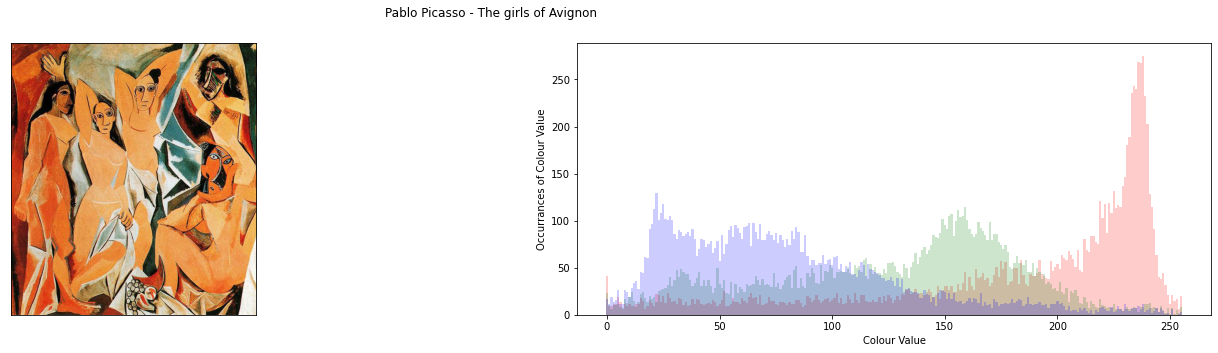

In [9]:
# define image to process
image_tag  = "10_0331"
image_path = "".join([image_file_path, "full_image_", image_tag ,".jpg"])

# plot the image and the distribusion of colours
plot_colours(image_process(image_path), image_tag)

For the demo we: <br/>

- Define an __IMAGE_TAG__ to use. <br/>
- Construct the __path__ to the image file. <br/>
- Pass the __path__ and the __IMAGE_TAG__ to the <code>plot_colurs()</code> function so that the artwork image and a histogram of the __R, G, B__ values are plotted side by side.

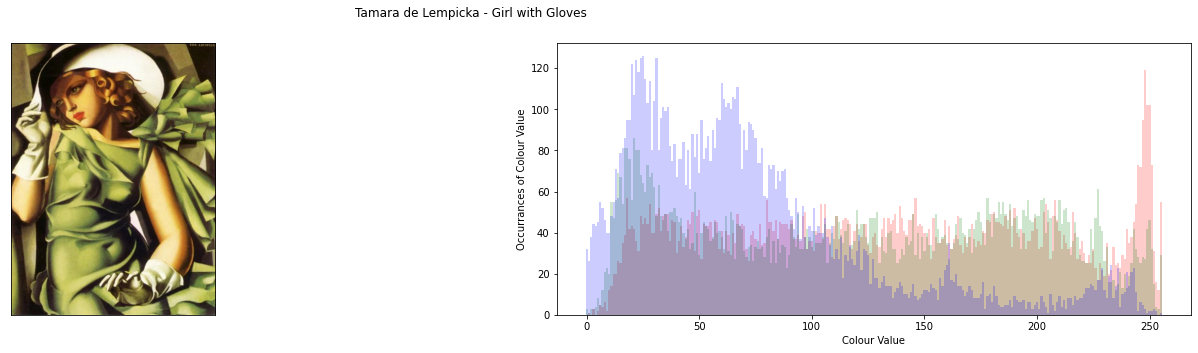

In [10]:
# define image to process
image_tag  = "13_0037"
image_path = "".join([image_file_path, "full_image_", image_tag ,".jpg"])

# plot the image and the distribusion of colours
plot_colours(image_process(image_path), image_tag)

For the demo we: <br/>

- Define an __IMAGE_TAG__ to use. <br/>
- Construct the __path__ to the image file. <br/>
- Pass the __path__ and the __IMAGE_TAG__ to the <code>plot_colurs()</code> function so that the artwork image and a histogram of the __R, G, B__ values are plotted side by side.

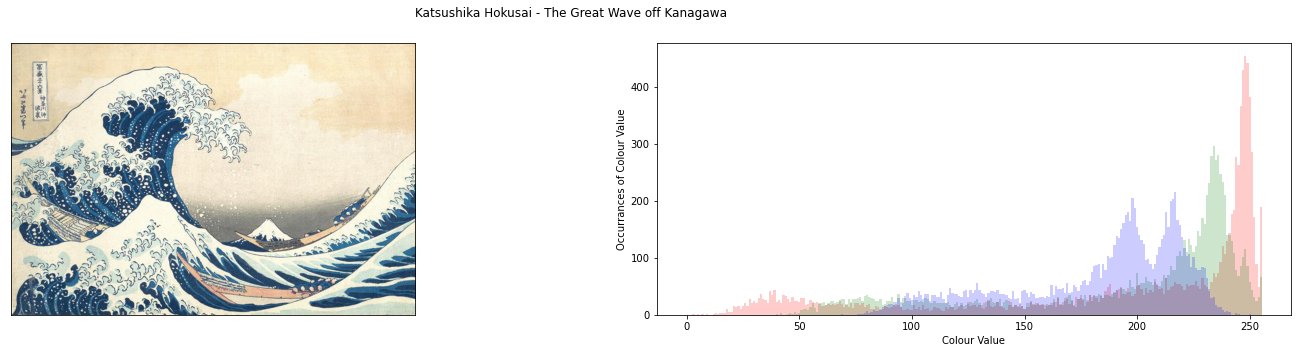

In [11]:
# define image to process
image_tag  = "07_0040"
image_path = "".join([image_file_path, "full_image_", image_tag ,".jpg"])

# plot the image and the distribusion of colours
plot_colours(image_process(image_path), image_tag)

For the demo we: <br/>

- Define an __IMAGE_TAG__ to use. <br/>
- Construct the __path__ to the image file. <br/>
- Pass the __path__ and the __IMAGE_TAG__ to the <code>plot_colurs()</code> function so that the artwork image and a histogram of the __R, G, B__ values are plotted side by side.

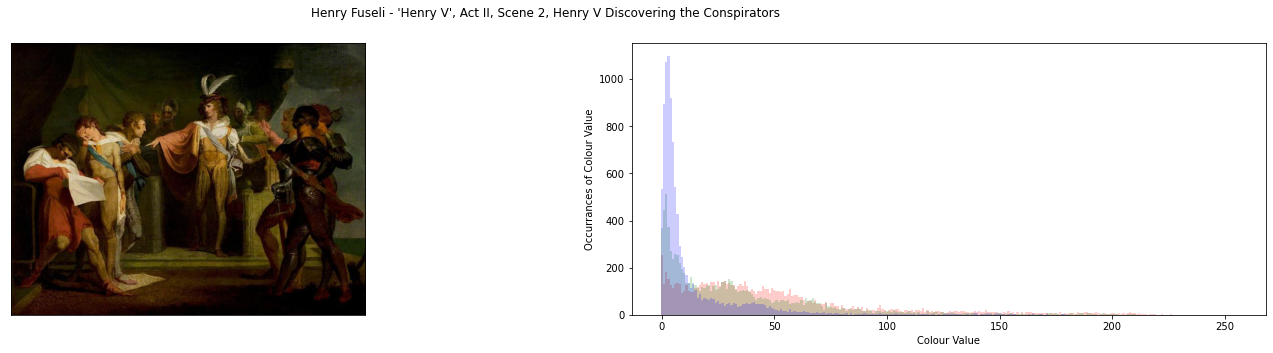

In [12]:
# define image to process
image_tag  = "04_0000"
image_path = "".join([image_file_path, "full_image_", image_tag ,".jpg"])

# plot the image and the distribusion of colours
plot_colours(image_process(image_path), image_tag)

## Spliting the Datasets into __Train__, __Test__ & __Validation__ Subsets
Both _genre_ & _artist_ colour sets have __3306__ entries. But, the _style_ colour set has __3742__. This is because an artwork may have more than one sytle associated with it. To allow the _colour sets_ to be split into _train_, _test_ & _validation_ subsets the _image_tag_ must be used to decide the final set detination. Here we perfor a double _train_test_split_ to achieve a splt ratio of approx: __70%__, __20%__ & __10%__.
<br/>
Create a simple query against the RDBMS to return a list of all _IMAGE_TAGs_. <br/>__NOTE:__ The splits are kept consistence with the use of the <code>RANDOM_STATE</code> being set throughout the project to value: __42__.

In [13]:
# NOTE: select a list of unique image tags
query_string = """
SELECT IMAGE_TAG
FROM   ARTWORK_IMAGE
"""

# create the results dataframe
i_tags = pd.read_sql_query(query_string, conn)

# using the train test split we first extract our taining set which leaves a remainder
train_tags   , remainder_tags, _, _ = train_test_split(i_tags        , i_tags        , test_size = 0.3, random_state = RANDOM_STATE)

# now the reaminder is is split into a test and a validation set
validate_tags, test_tags     , _, _ = train_test_split(remainder_tags, remainder_tags, test_size = 0.7, random_state = RANDOM_STATE)

# create a list of image tags for each grouping
train_tags    = train_tags[   "image_tag"].to_numpy()
test_tags     = test_tags[    "image_tag"].to_numpy()
validate_tags = validate_tags["image_tag"].to_numpy()

## Build the __Genre__ Colour Set Arrays

Query the RDBMS to return a list of all __IMAGE_TAG__ values and the associated __GENRE__ catagories.

In [14]:
# define query
query_string = """
SELECT IMAGE_TAG,
       GENRE
FROM   GENRE         AS A,
       ARTWORK       AS B,
       ARTWORK_IMAGE AS C
WHERE  A.ID = B.GENRE_ID
AND    B.ID = C.ARTWORK_ID
"""
    
# execute query
genre_query_result = pd.read_sql_query(query_string, conn)

Here we loop through every every __IMAGE_TAG__ and identify if the image colour data should be in the __TRAIN, TEST__ or __VALIDATE__ dataset. Once the correct destination has been identified. The colour data is added to a set of array and finally written to one of three compressed data file.

In [15]:
# define feature set arrays
colours_tr   = []
colours_te   = []
colours_va   = []
genre_tr     = []
genre_te     = []
genre_va     = []
image_tag_tr = []
image_tag_te = []
image_tag_va = []

# loop through selection rows
for index, row in genre_query_result.iterrows():

    #read image 
    image_path = "".join([image_file_path, "full_image_", row["image_tag"] ,".jpg"])
    
    # get the image colours
    image_colours = image_process(image_path)
    
    # check in smallest dataset and then second 
    # smallest dataset for speed
    if row["image_tag"] in validate_tags:
        # append colours
        colours_va.append(image_colours     )
        genre_va.append(    row["genre"]    )
        image_tag_va.append(row["image_tag"])
    elif row["image_tag"] in test_tags:
        # append colours
        colours_te.append(image_colours     )
        genre_te.append(    row["genre"]    )
        image_tag_te.append(row["image_tag"])
    else:
        # append colours
        colours_tr.append(image_colours     )
        genre_tr.append(    row["genre"]    )
        image_tag_tr.append(row["image_tag"])
    
 # write files
savez_compressed("".join([colour_sets,"genre_train_colours"    ]),  colours_tr, genre_tr, image_tag_tr)
savez_compressed("".join([colour_sets,"genre_test_colours"     ]),  colours_te, genre_te, image_tag_te)
savez_compressed("".join([colour_sets,"genre_validation_colours"]), colours_va, genre_va, image_tag_va)

## Build the __Style__ Colour Set Arrays

Query the RDBMS to return a list of all __IMAGE_TAG__ values and the associated __STYLE__ catagories.

In [16]:
# NOTE: we generate additonal records here becaus an artwork can be listed with more than one style
query_string = """
SELECT IMAGE_TAG,
       STYLE
FROM   STYLE         AS A,
       ARTWORK_STYLE AS B,
       ARTWORK_IMAGE AS C
WHERE   B.STYLE_ID  = A.ID   
AND    C.ARTWORK_ID = B.ARTWORK_ID
"""
    
style_query_result = pd.read_sql_query(query_string, conn)

Here we loop through every every __IMAGE_TAG__ and identify if the image colour data should be in the __TRAIN, TEST__ or __VALIDATE__ dataset. Once the correct destination has been identified. The colour data is added to a set of array and finally written to one of three compressed data file.

In [17]:
# define feature set arrays
colours_tr   = []
colours_te   = []
colours_va   = []
style_tr     = []
style_te     = []
style_va     = []
image_tag_tr = []
image_tag_te = []
image_tag_va = []

# loop through selection rows
for index, row in style_query_result.iterrows():

    #read image 
    image_path = "".join([image_file_path, "full_image_", row["image_tag"] ,".jpg"])
    
    # get the image colours
    image_colours = image_process(image_path)
    
    # check in smallest dataset and then second 
    # smallest dataset for speed
    if row["image_tag"] in validate_tags:
        # append colours
        colours_va.append(image_colours     )
        style_va.append(    row["style"]    )
        image_tag_va.append(row["image_tag"])
    elif row["image_tag"] in test_tags:
        # append colours
        colours_te.append(image_colours     )
        style_te.append(    row["style"]    )
        image_tag_te.append(row["image_tag"])
    else:
        # append colours
        colours_tr.append(image_colours     )
        style_tr.append(    row["style"]    )
        image_tag_tr.append(row["image_tag"])
    
 # write files
savez_compressed("".join([colour_sets,"style_train_colours"    ]),  colours_tr, style_tr, image_tag_tr)
savez_compressed("".join([colour_sets,"style_test_colours"     ]),  colours_te, style_te, image_tag_te)
savez_compressed("".join([colour_sets,"style_validation_colours"]), colours_va, style_va, image_tag_va)

## Build the __Artist__ Colour Set Arrays

Query the RDBMS to return a list of all __IMAGE_TAG__ values and the associated __ARTIST__ name.

In [18]:
# NOTE: we generate additonal records here becaus an artwork can be listed with more than one style
query_string = """
SELECT IMAGE_TAG,
       NAME
FROM   ARTWORK       AS A,
       ARTIST        AS B,
       ARTWORK_IMAGE AS C
WHERE  A.ARTIST_ID = B.ID   
AND    A.ID        = C.ARTWORK_ID
"""
    
artist_query_result = pd.read_sql_query(query_string, conn)

Here we loop through every every __IMAGE_TAG__ and identify if the image colour data should be in the __TRAIN, TEST__ or __VALIDATE__ dataset. Once the correct destination has been identified. The colour data is added to a set of array and finally written to one of three compressed data file.

In [19]:
# define feature set arrays
colours_tr   = []
colours_te   = []
colours_va   = []
artist_tr    = []
artist_te    = []
artist_va    = []
image_tag_tr = []
image_tag_te = []
image_tag_va = []

# loop through selection rows
for index, row in artist_query_result.iterrows():

    #read image 
    image_path = "".join([image_file_path, "full_image_", row["image_tag"] ,".jpg"])
    
    # get the image colours
    image_colours = image_process(image_path)
    
    # check in smallest dataset and then second 
    # smallest dataset for speed
    if row["image_tag"] in validate_tags:
        # append colours
        colours_va.append(image_colours     )
        artist_va.append(   row["name"]     )
        image_tag_va.append(row["image_tag"])
    elif row["image_tag"] in test_tags:
        # append colours
        colours_te.append(image_colours     )
        artist_te.append(   row["name"]     )
        image_tag_te.append(row["image_tag"])
    else:
        # append colours
        colours_tr.append(image_colours     )
        artist_tr.append(   row["name"]     )
        image_tag_tr.append(row["image_tag"])
    
 # write files
savez_compressed("".join([colour_sets,"artist_train_colours"    ]),  colours_tr, artist_tr, image_tag_tr)
savez_compressed("".join([colour_sets,"artist_test_colours"     ]),  colours_te, artist_te, image_tag_te)
savez_compressed("".join([colour_sets,"artist_validation_colours"]), colours_va, artist_va, image_tag_va)